In [2]:
!pip install datasets

     |████████████████████████████████| 325 kB 4.7 MB/s 
     |████████████████████████████████| 136 kB 56.4 MB/s 
     |████████████████████████████████| 1.1 MB 49.7 MB/s 
     |████████████████████████████████| 77 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 54.7 MB/s 
     |████████████████████████████████| 127 kB 53.1 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 59.9 MB/s 
     |████████████████████████████████| 271 kB 57.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import functools
import sys
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torchtext
import tqdm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Visualize dialogue corpus and show stats of the train and test file.

In [7]:
train_data='/content/drive/MyDrive/mini_daily_dialog/train.csv'
test_data='/content/drive/MyDrive/mini_daily_dialog/test.csv'
data_train=pd.read_csv(train_data)
data_test=pd.read_csv(test_data)

In [8]:
data_train['act'].value_counts()

1    2859
2    1497
3     426
4     308
Name: act, dtype: int64

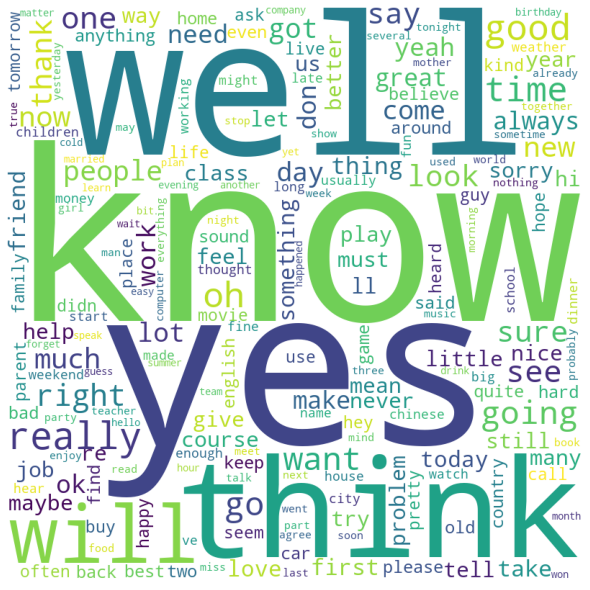

In [12]:
# For complete train

group_of_words =''
stopwords = set(STOPWORDS)
for word in data_train['utterance']:
    word = str(word)
    token = word.split()
    for i in range(len(token)):
        token[i] = token[i].lower()
    group_of_words+= " ".join(token)+" "
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(group_of_words)
plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

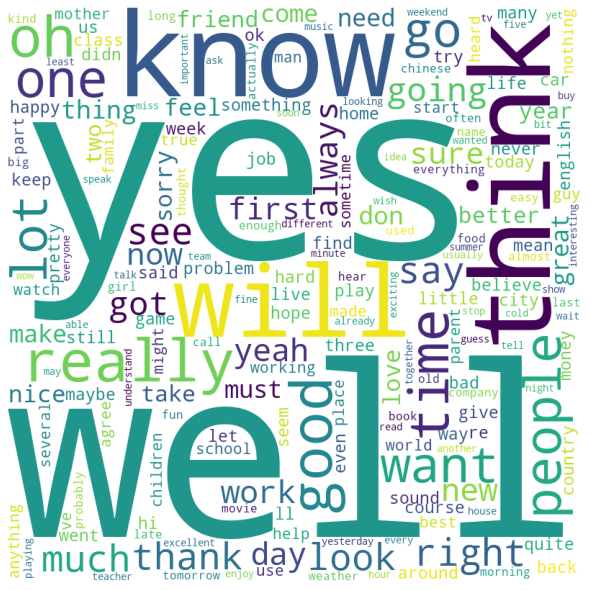

In [13]:
# For act 1

group_of_words = ''
stopwords = set(STOPWORDS)
for words in data_train[data_train['act'] == 1]['utterance']:
    words = str(words)
    tokens = words.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    group_of_words+= " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(group_of_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

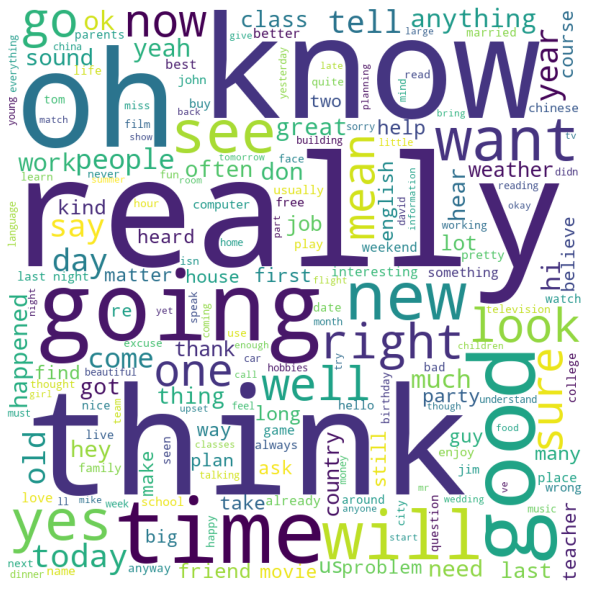

In [14]:
# For act 2

group_of_words = ''
stopwords = set(STOPWORDS)
for words in data_train[data_train['act'] == 2]['utterance']:
    words = str(words)
    tokens = words.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    group_of_words+= " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(group_of_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

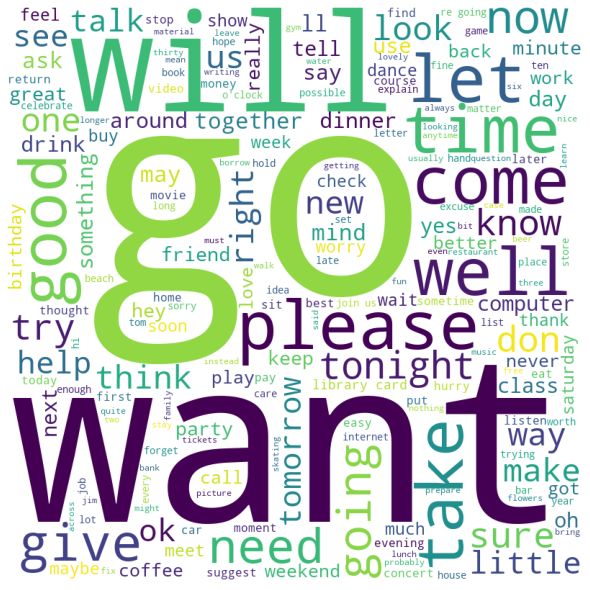

In [15]:
# For act 3

group_of_words = ''
stopwords = set(STOPWORDS)
for words in data_train[data_train['act'] == 3]['utterance']:
    words = str(words)
    tokens = words.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    group_of_words+= " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(group_of_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

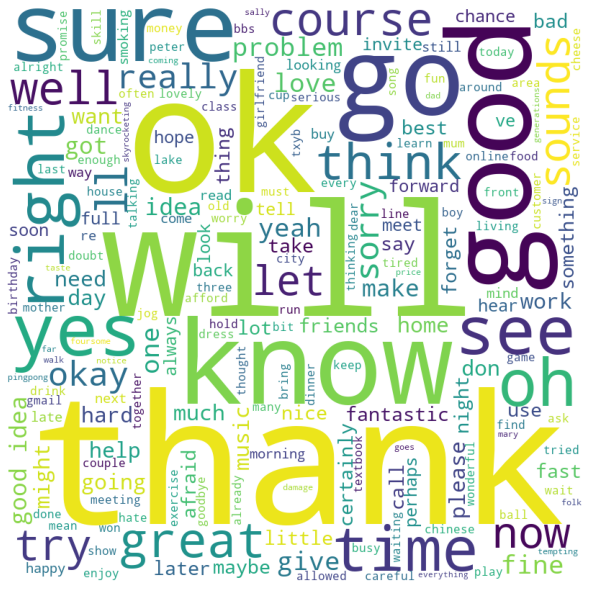

In [48]:
# For act 4

group_of_words = ''
stopwords = set(STOPWORDS)
for words in data_train[data_train['act'] == 4]['utterance']:
    words = str(words)
    tokens = words.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    group_of_words+= " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(group_of_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [16]:
# Loading the data

train_data = pd.read_csv('/content/drive/MyDrive/mini_daily_dialog/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/mini_daily_dialog/test.csv')

In [17]:
# Tokenizer Object

utterance = torchtext.legacy.data.Field(tokenizer_language = 'en_core_web_sm',tokenize = 'spacy', )
act = torchtext.legacy.data.LabelField(dtype=torch.long)

In [18]:
train_data.to_csv('train.csv', index = False)
test_data.to_csv('test.csv', index = False)

In [19]:
train_size = int(0.8 * len(train_data))
validation_size = len(train_data) - train_size
train_data, validation_data = torch.utils.data.random_split(train_data, [train_size, validation_size])

In [20]:
trainD, testD = torchtext.legacy.data.TabularDataset.splits(path = './', train = 'train.csv', test = 'test.csv', format = 'csv', fields = [('text', utterance), ('label', act)], skip_header = True)

In [21]:
# Building vocabulary

utterance.build_vocab(trainD)
act.build_vocab(trainD)

In [22]:
trainLoader, validationLoader, testLoader = torchtext.legacy.data.BucketIterator.splits((trainD, validation_data, testD), batch_size = 16, sort_key=lambda x: len(x.text), device = device)

In [23]:
vocab = utterance.vocab

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
def testAccuracy(loader, model, criterion):       
    correct=0                                               
    total=0                                                 
    total_loss=0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs = data.text.to(device)  
            labels = data.label.to(device)                                                                             
            out = model(inputs)                           
            loss = criterion(out, labels)                 
            _, predicted = torch.max(out.data, 1)         
            total += labels.size(0)                           
            correct += (predicted == labels).sum().item()     
            total_loss = total_loss + loss.item()         
    mean_val_accuracy = (100 * correct / total)               
    mean_val_loss = (total_loss)                            
    print('Test Accuracy: %d %%' % (mean_val_accuracy)) 

In [56]:
def f1(loader, model, criterion):       
    correct=0                                               
    total=0                                                 
    total_loss=0.0   
    y_true=[]
    y_pred=[]                                     
    model.eval()                                              
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs = data.text.to(device)  
            labels = data.label.to(device)                                                                             
            out = model(inputs)  
            loss = criterion(out, labels)                 
            _, predicted = torch.max(out.data, 1)         
            total += labels.size(0)                           
            correct += (predicted == labels).sum().item()     
            total_loss = total_loss + loss.item()  
            y_true.append(labels.tolist())
            y_pred.append(predicted.tolist())
    y_true = sum(y_true, [])
    y_pred= sum(y_pred, [])

    print(classification_report(y_true, y_pred))

In [26]:
class LSTM1(nn.Module):
    def __init__(self, inputdimenssion, embeddingsdimenssion, hiddendimenssion,outputfeatures):
        super(LSTM1, self).__init__()

        #EMBEDDINGS Layer
        self.embedding = nn.Embedding(inputdimenssion, embeddingsdimenssion)
        #LSTM Module
        self.lstm = nn.LSTM(embeddingsdimenssion, hiddendimenssion)
        #Linear Layer
        self.linear = nn.Linear(hiddendimenssion, out_features = outputfeatures)

    def forward(self, samples):
        output, (hidden, cell) = self.lstm(self.embedding(samples))
        hidden.squeeze_(0)
        output = self.linear(hidden)
        return output

In [60]:
# Plotting functions for loss

def train_validation_loss(lossEpoch):
    plt.plot(list(range(5)),lossEpoch)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. No. of epochs')

# LSTM for X=0

In [76]:
lstm = LSTM1(len(utterance.vocab), 20, 128, 4)
lstm = lstm.to(device)
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 5

The training loss is  1.293670415878296  in epoch number  1
The training loss is  0.5046594738960266  in epoch number  2
The training loss is  0.6884875893592834  in epoch number  3
The training loss is  0.6545974612236023  in epoch number  4
The training loss is  0.5186690092086792  in epoch number  5
Test Accuracy: 76 %
              precision    recall  f1-score   support

           0       0.74      0.99      0.84       363
           1       0.83      0.90      0.86       217
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        59

    accuracy                           0.77       722
   macro avg       0.39      0.47      0.43       722
weighted avg       0.62      0.77      0.68       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


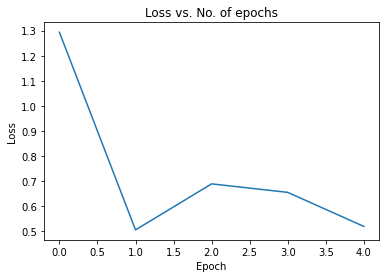

In [77]:
X=0
lossEpoch = []
for epoch in range(5):
    lstm.train()
    for inx, d in enumerate(trainLoader):
        interList = []
        # t=torch.empty()
        data = d.text.to(device)
        labels = d.label.to(device)

        output = lstm(data)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossEpoch.append(loss.item())
    print("The training loss is ",loss.item()," in epoch number ",(epoch+1))

testAccuracy(testLoader,lstm,criterion)
train_validation_loss(lossEpoch)
f1(testLoader,lstm,criterion)

In [82]:
print("The Accuracy calculated before Saving Model ")
testAccuracy(testLoader,lstm,criterion)
model_path = '/content/drive/MyDrive/mini_daily_dialog/'
torch.save(lstm.state_dict(), os.path.join(model_path, "model_lstm_0.pth"))
lstm_model_0=lstm
lstm_model_0.load_state_dict(torch.load(os.path.join(model_path, "model_lstm_0.pth")))
print("The Accuracy calculated after Saving Model ")
testAccuracy(testLoader,lstm_model_0,criterion)

The Accuracy calculated before Saving Model 
Test Accuracy: 76 %
The Accuracy calculated after Saving Model 
Test Accuracy: 76 %


# LSTM for X=1

In [83]:
lstm = LSTM1(len(utterance.vocab), 20, 128, 4)
lstm = lstm.to(device)
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 5

The training loss is  1.0583208799362183  in epoch number  1
The training loss is  0.9247939586639404  in epoch number  2
The training loss is  1.1025513410568237  in epoch number  3
The training loss is  1.269026756286621  in epoch number  4
The training loss is  1.1136547327041626  in epoch number  5
Test Accuracy: 50 %
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       363
           1       0.00      0.00      0.00       217
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        59

    accuracy                           0.50       722
   macro avg       0.13      0.25      0.17       722
weighted avg       0.25      0.50      0.34       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


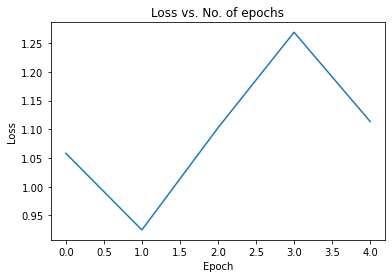

In [84]:
X=1
lossEpoch = []
for epoch in range(epochs):
    lstm.train()
    for ind, data in enumerate(trainLoader):
        interList = []
        arrT=torch.transpose(data.text,0,1)
        emptyList = []
        for i in arrT[0]:
          emptyList.append(0)
        interList.append(arrT[0].tolist()+ emptyList)
        for i in range(1, len(arrT)):
          concat = arrT[i].tolist() + arrT[i-1].tolist()
          interList.append(concat)
        v = torch.tensor(interList).to(device)
        v=torch.transpose(v,0,1)
        labels = data.label.to(device)
        output = lstm(v)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lossEpoch.append(loss.item())
    print("The training loss is ",loss.item()," in epoch number ",(epoch+1))

testAccuracy(testLoader,lstm,criterion)
train_validation_loss(lossEpoch)
f1(testLoader,lstm,criterion)

In [85]:
print("The Accuracy calculated before Saving Model ")
testAccuracy(testLoader,lstm,criterion)
model_path = '/content/drive/MyDrive/mini_daily_dialog/'
torch.save(lstm.state_dict(), os.path.join(model_path, "model_lstm_1.pth"))
lstm_model_1=lstm
lstm_model_1.load_state_dict(torch.load(os.path.join(model_path, "model_lstm_1.pth")))
print("The Accuracy calculated after Saving Model ")
testAccuracy(testLoader,lstm_model_1,criterion)

The Accuracy calculated before Saving Model 
Test Accuracy: 50 %
The Accuracy calculated after Saving Model 
Test Accuracy: 50 %


# LSTM with X=2

In [86]:
lstm = LSTM1(len(utterance.vocab), 20, 128, 4)
lstm = lstm.to(device)
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 5

The training loss is  0.10396786779165268  in epoch number  1
The training loss is  0.002299167914316058  in epoch number  2
The training loss is  0.0008299220935441554  in epoch number  3
The training loss is  0.0004582001129165292  in epoch number  4
The training loss is  0.0002899660903494805  in epoch number  5
Test Accuracy: 22 %
              precision    recall  f1-score   support

           0       0.42      0.30      0.35       363
           1       0.26      0.03      0.05       217
           2       0.12      0.54      0.20        83
           3       0.05      0.05      0.05        59

    accuracy                           0.23       722
   macro avg       0.21      0.23      0.16       722
weighted avg       0.31      0.23      0.22       722



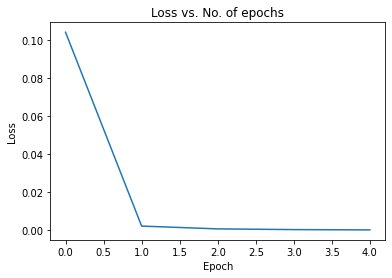

In [87]:
X=2
lossEpoch = []
for epoch in range(epochs):
    lstm.train()
    for ind, data_test in enumerate(trainLoader):
        interList = []
        arrT=torch.transpose(data.text,0,1)

        emptyList = []
        for i in arrT[0]:
          emptyList.append(0)
        interList.append(arrT[0].tolist()+ emptyList + emptyList)

        interList.append(arrT[1].tolist()+ arrT[0].tolist() + emptyList)


        for i in range(2, len(arrT)):
          concat = arrT[i].tolist() + arrT[i-1].tolist() +  arrT[i-2].tolist()
          interList.append(concat)
        v = torch.tensor(interList).to(device)
        v=torch.transpose(v,0,1)
        labels = data.label.to(device)
        output = lstm(v)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossEpoch.append(loss.item())
    print("The training loss is ",loss.item()," in epoch number ",(epoch+1))

testAccuracy(testLoader,lstm,criterion)
train_validation_loss(lossEpoch)
f1(testLoader,lstm,criterion)

In [88]:
print("The Accuracy calculated before Saving Model ")
testAccuracy(testLoader,lstm,criterion)
model_path = '/content/drive/MyDrive/mini_daily_dialog/'
torch.save(lstm.state_dict(), os.path.join(model_path, "model_lstm_2.pth"))
lstm_model_2=lstm
lstm_model_2.load_state_dict(torch.load(os.path.join(model_path, "model_lstm_2.pth")))
print("The Accuracy calculated after Saving Model ")
testAccuracy(testLoader,lstm_model_2,criterion)

The Accuracy calculated before Saving Model 
Test Accuracy: 22 %
The Accuracy calculated after Saving Model 
Test Accuracy: 22 %


# LSTM with X=3

In [90]:
lstm = LSTM1(len(utterance.vocab), 20, 128, 4)
lstm = lstm.to(device)
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 5

The training loss is  1.3676700592041016  in epoch number  1
The training loss is  0.8960292339324951  in epoch number  2
The training loss is  1.2383928298950195  in epoch number  3
The training loss is  0.9119448065757751  in epoch number  4
The training loss is  0.8254332542419434  in epoch number  5
Test Accuracy: 50 %
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       363
           1       0.00      0.00      0.00       217
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        59

    accuracy                           0.50       722
   macro avg       0.13      0.25      0.17       722
weighted avg       0.25      0.50      0.34       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


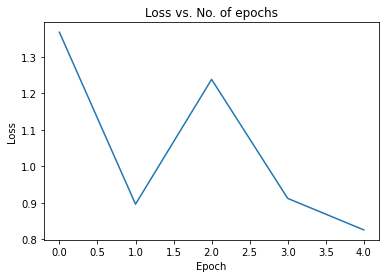

In [91]:
X=3
lossEpoch = []
for epoch in range(epochs):
    lstm.train()
    for ind, data in enumerate(trainLoader):
      if len(data) > 2:
        interList = []
        arrT=torch.transpose(data.text,0,1)

        emptyList = []
        for i in arrT[0]:
          emptyList.append(0)
        interList.append(arrT[0].tolist()+ emptyList + emptyList + emptyList)

        interList.append(arrT[1].tolist()+ arrT[0].tolist() + emptyList + emptyList)

        interList.append(arrT[2].tolist()+ arrT[1].tolist() + arrT[0].tolist() + emptyList)
        


        for i in range(3, len(arrT)):
          concat = arrT[i].tolist() + arrT[i-1].tolist() +  arrT[i-2].tolist() + arrT[i-3].tolist() 
          interList.append(concat)
        v = torch.tensor(interList).to(device)
        v=torch.transpose(v,0,1)
        labels = data.label.to(device)
        output = lstm(v)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossEpoch.append(loss.item())
    print("The training loss is ",loss.item()," in epoch number ",(epoch+1))

testAccuracy(testLoader,lstm,criterion)
train_validation_loss(lossEpoch)
f1(testLoader,lstm,criterion)

In [92]:
print("The Accuracy calculated before Saving Model ")
testAccuracy(testLoader,lstm,criterion)
model_path = '/content/drive/MyDrive/mini_daily_dialog/'
torch.save(lstm.state_dict(), os.path.join(model_path, "model_lstm_3.pth"))
lstm_model_3=lstm
lstm_model_3.load_state_dict(torch.load(os.path.join(model_path, "model_lstm_3.pth")))
print("The Accuracy calculated after Saving Model ")
testAccuracy(testLoader,lstm_model_3,criterion)

The Accuracy calculated before Saving Model 
Test Accuracy: 50 %
The Accuracy calculated after Saving Model 
Test Accuracy: 50 %


# LSTM with X=4

In [93]:
lstm = LSTM1(len(utterance.vocab), 20, 128, 4)
lstm = lstm.to(device)
lr = 5e-4
optimizer = optim.Adam(lstm.parameters(), lr=lr)
epochs = 5

The training loss is  1.1891443729400635  in epoch number  1
The training loss is  0.8510355949401855  in epoch number  2
The training loss is  1.1833921670913696  in epoch number  3
The training loss is  1.0351001024246216  in epoch number  4
The training loss is  0.8852114081382751  in epoch number  5
Test Accuracy: 50 %
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       363
           1       0.00      0.00      0.00       217
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        59

    accuracy                           0.50       722
   macro avg       0.13      0.25      0.17       722
weighted avg       0.25      0.50      0.34       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


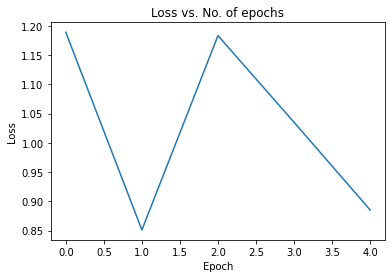

In [94]:
X=4
lossEpoch = []
for epoch in range(epochs):
    lstm.train()
    for ind, data in enumerate(trainLoader):
      if len(data) > 3:

        interList = []
        arrT=torch.transpose(data.text,0,1)

        emptyList = []
        for i in arrT[0]:
          emptyList.append(0)
        interList.append(arrT[0].tolist()+ emptyList + emptyList + emptyList + emptyList)
        interList.append(arrT[1].tolist()+ arrT[0].tolist() + emptyList + emptyList + emptyList)
        interList.append(arrT[2].tolist()+ arrT[1].tolist() + arrT[0].tolist() + emptyList + emptyList)
        interList.append(arrT[3].tolist() + arrT[2].tolist()+ arrT[1].tolist() + arrT[0].tolist() + emptyList)



        for i in range(4, len(arrT)):
          concat = arrT[i].tolist() + arrT[i-1].tolist() +  arrT[i-2].tolist() + arrT[i-3].tolist() + arrT[i-4].tolist() 
          interList.append(concat)
        v = torch.tensor(interList)
        v=torch.transpose(v,0,1).to(device)
        labels = data.label.to(device)
        output = lstm(v)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    lossEpoch.append(loss.item())
    print("The training loss is ",loss.item()," in epoch number ",(epoch+1))
testAccuracy(testLoader,lstm,criterion)
train_validation_loss(lossEpoch)
f1(testLoader,lstm,criterion)

In [95]:
print("The Accuracy calculated before Saving Model ")
testAccuracy(testLoader,lstm,criterion)
model_path = '/content/drive/MyDrive/mini_daily_dialog/'
torch.save(lstm.state_dict(), os.path.join(model_path, "model_lstm_4.pth"))
lstm_model_4=lstm
lstm_model_4.load_state_dict(torch.load(os.path.join(model_path, "model_lstm_4.pth")))
print("The Accuracy calculated after Saving Model ")
testAccuracy(testLoader,lstm_model_4,criterion)

The Accuracy calculated before Saving Model 
Test Accuracy: 50 %
The Accuracy calculated after Saving Model 
Test Accuracy: 50 %
